In [4]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## The Extraordinary Power of Explanatory Power

The strength of multiple linear regression lies in its ability to provide straightforward and interpretable solutions that not only predict future outcomes, but also provide insight into the underlying processes that create these outcomes.  For example, after fitting the following model:

$$HourlyWidgetProduction = \alpha + \beta_1WorkerAgeFrom18+ \beta_2WorkerYearsinJob + \beta_3IsRoundWidget$$

we get these parameters:
$$\alpha = 2$$
$$\beta_1 = .1$$
$$\beta_2 = .2$$
$$\beta_3 = 4$$

Using those parameters, we learn that round widgets are twice as fast to produce as non-round widgets. We can tell because $\alpha$ represents the intercept, the hourly rate of production for widgets that are not round (2 an hour) and $\beta_3$ represents the difference between the intercept and the hourly rate of production for round widgets (also 2 an hour, for a total of 4 round widgets an hour).

We also learn that for every year a worker ages after the age of 18, their hourly production-rate goes up by .1 ($\beta_1$).  In addition, for every year a worker has been in that job, their hourly production-rate goes up by .2 ($\beta_2$).  

Furthermore, using this model, we can predict that a 20-year-old worker who has been in the job for a year and is making only round widgets will make $2 + .1*2 + .2*1 + 4 = 6.3$ round widgets an hour.

Finally, and probably of greatest interest, we get an **R-Squared** value.  This is a proportion (between 0 and 1) that expresses how much variance in the outcome variable our model was able to explain.  Higher $R^2$ values are better to a point-- a low $R^2$ indicates that our model isn't explaining much information about the outcome, which means it will not give very good predictions.  However, a very high $R^2$ is a warning sign for overfitting.  No dataset is a perfect representation of reality, so a model that perfectly fits our data ($R^2$ of 1 or close to 1) is likely to be biased by quirks in the data, and will perform less well on the test-set.

Here's an example using a toy advertising dataset:


In [10]:
data['sqrt_TV'] = np.sqrt(data.TV)
data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales,sqrt_TV
0,1,230.100,37.800,69.200,22.100,15.169
1,2,44.500,39.300,45.100,10.400,6.671
2,3,17.200,45.900,69.300,9.300,4.147
3,4,151.500,41.300,58.500,18.500,12.309
4,5,180.800,10.800,58.400,12.900,13.446


In [11]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
data['sqrt_TV'] = np.sqrt(data.TV)
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['sqrt_TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales,sqrt_TV
0,1,230.100,37.800,69.200,22.100,15.169
1,2,44.500,39.300,45.100,10.400,6.671
2,3,17.200,45.900,69.300,9.300,4.147
3,4,151.500,41.300,58.500,18.500,12.309
4,5,180.800,10.800,58.400,12.900,13.446



Coefficients: 
 [[ 9.74947557e-01  1.94767873e-01 -5.25277959e-04]]

Intercept: 
 [-1.60927984]

R-squared:
0.9289549053811124


The model where the outcome Sales is predicted by the features TV, Radio, and Newspaper explains 89.7% of the variance in Sales.  Note that we don't know from these results how much of that variance is explained by each of the three features.  Looking at the coefficients, there appears to be a base rate of Sales that happen even with no ads in any medium (intercept: 2.939) and sales have the highest per-unit increase when ads are on the radio (0.189).  

## Assumptions of Multivariable Linear Regression

For regression to work its magic, inputs to the model need to be consistent with four assumptions:


### Assumption one: linear relationship

As mentioned earlier, features in a regression need to have a linear relationship with the outcome.  If the relationship is non-linear, the regression model will try to find any hint of a linear relationship, and only explain that – with predictable consequences for the validity of the model.

Sometimes this can be fixed by applying a non-linear transformation function to a feature.  For example, if the relationship between feature and outcome is quadratic and all feature scores are > 0, we can take the square root of the features, resulting in a linear relationship between the outcome and sqrt(feature).  


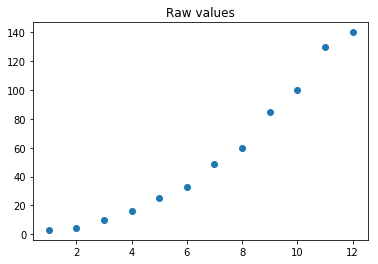

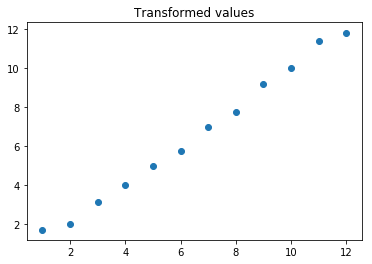

In [40]:
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

When interpreting features with non-linear transformations, it is important to keep the transformation in mind.  For example, in the equation $y = 2log({x})$, y increases by one unit for every two-unit increase in $log({x})$.  The relationship between y and x, however, is non-linear, and the amount of change in y varies based on the absolute value of x:

|x	|log(x)|	y|
|--|--|--|
|1	|0	|0|
|10	|1	|2|
|100	|2	|4|	
|1000|	3	|6|

So a one-unit change in x from 1 to 2 will result in a much greater change in y than a one-unit change in x from 100 to 101.

There are many variable transformations.  For a deep dive, check out the Variable Linearization section of [Fifty Ways to Fix Your Data](https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/).

### Assumption two: multivariate normality

The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed.  Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.  

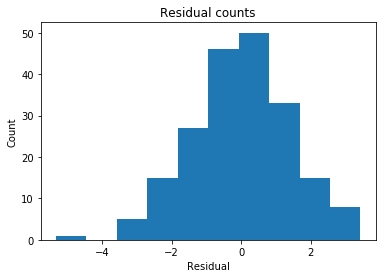

In [12]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#display(predicted)

In [15]:
test = data
test['predicted'] = predicted
test['residuals'] = actual - predicted

In [16]:
outlier_mask = test.residuals < -4
higher_tv_mask = (test.TV > 270)
lower_tv_mask = (test.TV < 9)

In [17]:
test[outlier_mask]

,Unnamed: 0,TV,Radio,Newspaper,Sales,sqrt_TV,predicted,residuals
130,131,0.700,39.600,8.700,1.600,0.837,6.915,-5.315


We notice residuals are largest when one or two media outlet spends are significantly low. This shows the synergistic relationship among these variables.

In [63]:
test[higher_tv_mask]

,Unnamed: 0,TV,Radio,Newspaper,Sales,predicted,residuals
17,18,281.400,39.600,55.800,24.400,23.225,1.175
30,31,292.900,28.300,43.200,21.400,21.634,-0.234
35,36,290.700,4.100,8.500,12.800,17.007,-4.207
42,43,293.600,27.700,1.800,20.700,21.596,-0.896
98,99,289.700,42.300,51.200,25.400,24.119,1.281
101,102,296.400,36.300,100.900,23.800,23.242,0.558
102,103,280.200,10.100,21.400,14.800,17.644,-2.844
137,138,273.700,28.900,59.700,20.800,20.851,-0.051
150,151,280.700,13.900,37.000,16.100,18.367,-2.267
169,170,284.300,10.600,6.400,15.000,17.942,-2.942


In [64]:
test[lower_tv_mask]

,Unnamed: 0,TV,Radio,Newspaper,Sales,predicted,residuals
5,6,8.700,48.900,75.000,7.200,12.478,-5.278
8,9,8.600,2.100,1.000,4.800,3.727,1.073
56,57,7.300,28.100,41.400,5.500,8.528,-3.028
78,79,5.400,29.900,9.400,5.300,8.813,-3.513
126,127,7.800,38.900,50.600,6.600,10.577,-3.977
130,131,0.700,39.600,8.700,1.600,10.428,-8.828
132,133,8.400,27.200,2.100,5.700,8.449,-2.749
155,156,4.100,11.600,5.700,3.200,5.308,-2.108


When TV is low, predictability is off


### Assumption three: homoscedasticity

The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance.  This leads to overconfidence in the accuracy of your model's predictions.

Some fixes to heteroscedasticity include transforming the dependent variable and adding features that target the poorly-estimated areas. For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.

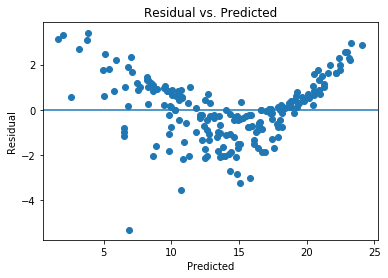

In [13]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.


In [18]:
z = (predicted - 10)(predicted - 20) / 35

TypeError: 'Series' object is not callable

In [32]:
z = data.predicted.subtract(10) * (data.predicted.subtract(20)) / 35

In [33]:
display(z.head())
predicted

0    0.152
1   -0.539
2   -0.331
3   -0.383
4   -0.656
Name: predicted, dtype: float64

array([20.50562226, 12.52511892, 11.33755233, 18.40407934, 13.57286613,
       10.75115545, 12.15966825, 12.89098894,  1.65831489, 12.66692568,
        7.43417161, 17.34860827,  9.9487621 ,  9.49400977, 18.70286938,
       21.28171855, 13.48713446, 22.42894453, 10.48410011, 14.86830614,
       18.16586888, 14.39347974,  5.00363593, 16.39960215,  8.53047787,
       14.87015101, 15.74540026, 16.73828369, 19.03513389,  9.67745524,
       20.56552489, 12.11865333,  8.27912748, 18.17487342,  8.19706684,
       15.80758795, 22.84671738, 16.41463789,  9.97317337, 20.43804536,
       16.5911919 , 17.84647248, 20.49033714, 14.03656706,  8.25798749,
       15.65747936,  9.53390618, 21.5645449 , 16.13737678,  8.62450607,
       12.75727089, 10.02755581, 20.83374492, 20.53258624, 19.79365513,
       21.73060814,  6.47611413, 13.49964536, 22.18662157, 18.28334732,
        5.90014156, 22.43838501, 16.47706222, 14.03165373, 17.87464768,
        8.30011127,  8.65273382, 12.71635607, 18.76284606, 21.28

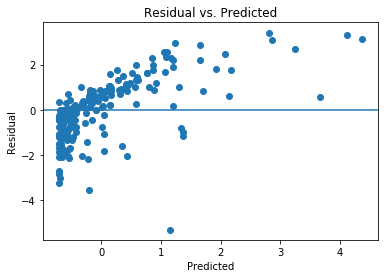

In [34]:
plt.scatter(z, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.


In [37]:
print(regr.score(z, Y))

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.1517679  -0.53928468 -0.3310422  -0.38320697 -0.65609397 -0.19849486
 -0.48378616 -0.58720207  4.37144461 -0.55876469  0.92119312 -0.55668683
  0.01471441  0.15188367 -0.32253595  0.41314251 -0.64889251  0.86254905
 -0.13161852 -0.71379019 -0.42792212 -0.70377523  2.14077984 -0.65831754
  0.48156333 -0.71380398 -0.69841081 -0.62795342 -0.24907699  0.09512808
  0.17071621 -0.47708118  0.57628935 -0.42629082  0.60799713 -0.69565148
  1.04488496 -0.65710856  0.00768531  0.13063821 -0.64194595 -0.48278841
  0.14696577 -0.68776563  0.58442093 -0.70193488  0.13937662  0.51694999
 -0.67732497  0.44705494 -0.57057618 -0.00785139  0.25807371  0.16027173
 -0.05773916  0.58003103  1.36161801 -0.6499696   0.76135799 -0.40627515
  1.65164068  0.86655919 -0.65195106 -0.68749444 -0.47818288  0.56824311
  0.43679394 -0.56528487 -0.30974256  0.41324234 -0.44199965 -0.33889846
  0.04199975 -0.15481047 -0.54732294 -0.22531305  2.86706285 -0.71050818
  1.36220196 -0.1041303  -0.47417263 -0.69895192 -0.20730525 -0.71398597
  0.31208104 -0.70738762 -0.49893443 -0.64802059 -0.53286594 -0.47571019
 -0.17081986  2.81904238 -0.19347442  0.28189349 -0.30507607 -0.60268753
 -0.57273405 -0.69920875  1.2052998  -0.48631869 -0.66903621  0.76387789
 -0.63494097 -0.71402472  0.03339603 -0.29169861  1.92308075  0.80550896
  4.12625476 -0.20837426 -0.70990265  0.29277666 -0.7007615  -0.64895105
 -0.67912913 -0.66056869 -0.55853217  1.08673606 -0.65281625  1.7095279
 -0.7134067   1.19844106 -0.64490108 -0.68902597 -0.158001    0.0643807
  0.43289536  1.06120143  0.85169437  0.59445547  1.15350745 -0.71325368
  1.34370524 -0.17463955 -0.42110265 -0.70092057 -0.23743081  0.03398607
  0.05306528  0.05747556 -0.01357605 -0.29850819 -0.18247105  0.16451129
 -0.21394932 -0.0842542  -0.71407892  1.16735439 -0.49720661  0.02210539
 -0.54793611 -0.19227459 -0.63872628 -0.28781627 -0.69334907  3.6638824
 -0.66717875 -0.15200656  0.35278364 -0.61595302 -0.7117956  -0.70269312
 -0.71197163 -0.4535882  -0.42274673 -0.68207023  0.05013812 -0.64238077
 -0.56760231 -0.61215208  0.87819815 -0.71418595  1.29552631 -0.52390347
 -0.6571215   1.66022108 -0.10235486 -0.55117244 -0.71423088 -0.58530809
 -0.27820712 -0.6758069   1.20959813  1.2359894  -0.44753949  0.3570925
 -0.08337848 -0.54298612 -0.52352607  2.17084876 -0.53857183  0.32719939
  3.25317953 -0.21968969 -0.56964564  2.06911756  0.38281497 -0.61855404
  1.09364992 -0.71407593].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Assumption four: low multicollinearity

Correlations among features should be low or nonexistent.  When features are correlated, they may both explain the same pattern of variance in the outcome.  The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other.  This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained.  However, if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

Multicollinearity can be fixed by PCA or by discarding some of the correlated features.

In [6]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


## Drill: fixing assumptions

Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality.  Use the cell(s) below to see what you can do to fix it.

In [7]:
# Your code here.

